In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

In [2]:
prod_df = pd.read_excel("./data/Prod_rev1.xlsx")

In [3]:
for col in prod_df.columns:
    try:
        new_col = prod_df[col].replace("-", None).astype(float)
        prod_df[col] = new_col
    except:
        print(f"'{col}' is not convertible to Float")

'Date' is not convertible to Float
'M/C' is not convertible to Float
'Ton' is not convertible to Float
'Status' is not convertible to Float
'ItemId' is not convertible to Float
'ItemName' is not convertible to Float
'Material Code' is not convertible to Float
'Material Name' is not convertible to Float
'M/B  Code' is not convertible to Float
'M/B  Name' is not convertible to Float
'Colour' is not convertible to Float
'Customer' is not convertible to Float
'Group Industry' is not convertible to Float
'Die  No' is not convertible to Float
'Shief' is not convertible to Float
'Unnamed: 200' is not convertible to Float


In [4]:
# Calculate unplanned downtime by summing downtime of each category
prod_df['Unplanned stop time'] = prod_df['Down mold'] + prod_df['Up mold'] + prod_df['Setup equipment'] + prod_df['Adjust setup'] + prod_df['Qc accepted time'] + prod_df['Robot problem'] + prod_df['Adjust mc'] + prod_df['Change filter'] + prod_df['Change insert'] + prod_df['Change mat'] + prod_df['Change Date'] + prod_df['Clean machine'] + prod_df['Clean mold'] + prod_df['Clean screw'] + prod_df['Hopper problem'] + prod_df['Jig problem'] + prod_df['M/C problem'] + prod_df['Mold problem'] + prod_df['Nozzle Leak'] + prod_df['Clogged Gauge'] + prod_df['Part attached mold '] + prod_df['Power failure '] + prod_df['Contaminated pellets'] + prod_df['Pellets do not drop'] + prod_df['Mold waiting '] + prod_df['Packing waiting'] + prod_df['Assembly part waiting '] + prod_df['Waiting for crane '] + prod_df['Mold mounting waiting'] + prod_df['Waiting to adjust work'] + prod_df['Water leak '] + prod_df['Pellet drying'] + prod_df['Gauge pluged '] + prod_df['Waiting for pellets '] + prod_df['Runner attached mold '] 

C:\Users\Neo\AppData\Local\Temp\ipykernel_16060\2837624475.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prod_df['Unplanned stop time'] = prod_df['Down mold'] + prod_df['Up mold'] + prod_df['Setup equipment'] + prod_df['Adjust setup'] + prod_df['Qc accepted time'] + prod_df['Robot problem'] + prod_df['Adjust mc'] + prod_df['Change filter'] + prod_df['Change insert'] + prod_df['Change mat'] + prod_df['Change Date'] + prod_df['Clean machine'] + prod_df['Clean mold'] + prod_df['Clean screw'] + prod_df['Hopper problem'] + prod_df['Jig problem'] + prod_df['M/C problem'] + prod_df['Mold problem'] + prod_df['Nozzle Leak'] + prod_df['Clogged Gauge'] + prod_df['Part attached mold '] + prod_df['Power failure '] + prod_df['Contaminated pellets'] + prod_df['Pelle

In [5]:
i99_df = prod_df[prod_df['M/C'] == 'I-099'].copy()

In [6]:
i99_downtime = i99_df[['Date', 'Unplanned stop time']].groupby('Date').sum()

### Time Value Imputations

In this project, we will apply the trend and seasonality decomposition method to impute missing dates in our dataset.

In [7]:
# Get dates that are not included in the dataset
date_range = pd.date_range(start=i99_downtime.index.min(), end=i99_downtime.index.max(), freq="D")
missing_dates = date_range[~date_range.isin(i99_downtime.index)]

In [8]:
# Decompose time-series data into trends and seasonalities
unplanned_result = seasonal_decompose(i99_downtime['Unplanned stop time'], model="additive", period=12, extrapolate_trend='freq')

In [9]:
# Fill NaN trends using forward-filling method
unplanned_trend = unplanned_result.trend.reindex(date_range)
unplanned_trend_filled = unplanned_trend.ffill()

In [10]:
# Fill NaN seasonalities using forward-filling method
unplanned_seasonal = unplanned_result.seasonal.reindex(date_range)
unplanned_seasonal_filled = unplanned_seasonal.ffill()

In [11]:
# Get imputed data by trend + seasonality + residual
imputed_unplanned = unplanned_trend_filled + unplanned_seasonal_filled + unplanned_result.resid.reindex(date_range).fillna(0)

In [12]:
# Set imputed values less than 0 to 0
imputed_unplanned[imputed_unplanned < 0] = 0

In [13]:
imputed_downtime = pd.DataFrame({'Unplanned stop time': imputed_unplanned})

### Preprocessing

In [14]:
# train-test split for time series
train_set = imputed_downtime['Unplanned stop time'][:300].values.astype('float')
train_set.shape

(300,)

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_set_norm = scaler.fit_transform(train_set.reshape(-1, 1)).flatten()

In [16]:
#define function to create training set (ws days -> 1 day)
def create_data(seq, label):
    x_out, y_out = [], []
    #array to hold the out
    for i in range(seq.shape[0] - label):
        x = seq[i:i+label]          # 30 days in the past
        y = seq[i+label:i+label+1]  # next day
        x_out.append(x)
        y_out.append(y)
    
    
    return np.array(x_out), np.array(y_out).flatten()

In [17]:
#define window size
ws = 90 #use 60 days in the past to predict the next day

X, y = create_data(train_set_norm, ws)

### Modeling

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

In [19]:
# Initialize the estimator
model = GradientBoostingRegressor(random_state=0, n_estimators=500, learning_rate=0.05)
model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=500, random_state=0)

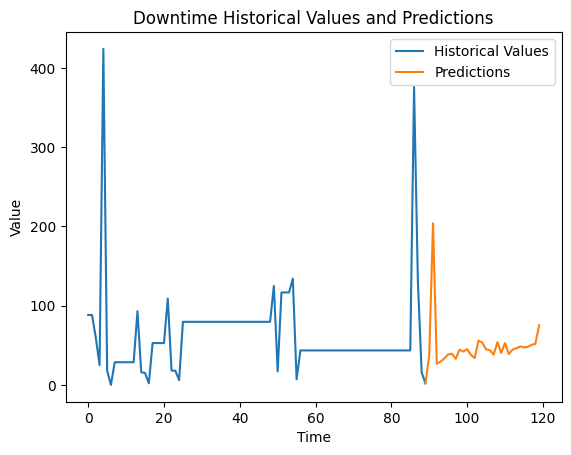

In [20]:
pred_range = 30
ref_set = train_set[-ws:]
inf_set = train_set_norm[-ws:]
inf_outputs = []
inf_output = None
fig_path = './figure/downtime_pred.png'

# Iteratively predict for next day using the inference set and previous predictions
for i in range(pred_range):
    if inf_output:
        inf_set = np.concatenate((inf_set[-ws+1:], inf_output))
        # inf_set = torch.cat((inf_set[-ws+1:], torch.FloatTensor([inf_output])))
        
    inf_output = model.predict(inf_set.reshape(1, -1))
    inf_outputs.append(inf_output[0])

inf_outputs = np.array(inf_outputs).reshape(-1, 1)
inf_outputs = scaler.inverse_transform(inf_outputs).flatten().tolist()
inf_outputs.insert(0, ref_set[-1])

# Plot the true values and the predictions
plt.plot(ref_set, label="Historical Values")
plt.plot(range(ws - 1, ws - 1 + len(inf_outputs)), inf_outputs, label="Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("Downtime Historical Values and Predictions")

plt.savefig(fig_path)
plt.show()
plt.close()